In [10]:
# Import needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.markers as mark
import tensorflow as tf
import sys 
from sklearn.preprocessing import MinMaxScaler
import math
# #from pandas_datareader import data as web
import finnhub
from datetime import datetime
from datetime import timezone
from time import time, sleep
import requests
# from google.colab import drive
# from google.colab import files
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras
# from kerastuner import HyperModel
# from kerastuner.tuners import RandomSearch 
# from kerastuner.tuners import Hyperband 
from pylab import rcParams

rcParams['figure.figsize'] = 16,9
rcParams['figure.facecolor'] = '#eeeeee'
plt.title('dummy')
plt.plot([1,3,2,4])
plt.close()

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt
import argparse
import backtrader.feeds as btfeeds
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Have all of our plots show automatically
%matplotlib inline

# Mount your Google Drive to the worksheet
# drive.mount('/content/drive')

In [11]:
#cfi82dhr01qq9nt1ure0cfi82dhr01qq9nt1ureg

In [12]:
# Global Parameters
ticker = "CVX"
granularity = "D"

# The amount of time divisions the LSTM model will look back for predictions
lookback_distance = 60

# Time Period for Stratagy Tuning
dt_start_model_parameter_tuning = datetime(2000, 10, 19)
dt_end_model_parameter_tuning = datetime(2006, 12, 31)

# Time Period for Model Building
dt_start_nn_model_training = datetime(2007, 1,1)
dt_end_nn_model_training = datetime(2013, 12, 1)

# Time Period for Backtesting
dt_start_backtest = datetime(2014, 1,1)
dt_end_backtest = datetime(2020, 12, 9)

# SMA Cross Stratagy Search Grid. This defines the windows we will test to find an optimal 
# fast and slow window combination.
pslow_start  = 30
pslow_end    = 200
pslow_step   = 10

pfast_start  = 30
pfast_end    = 200
pfast_step   = 10

# API Keys. Go to the finnhub website to get your API key and put it here.
finnhub_api_key = "cfi82dhr01qq9nt1ure0cfi82dhr01qq9nt1ureg"

# Drive Path
google_drive_path = "/content/drive/My Drive/"

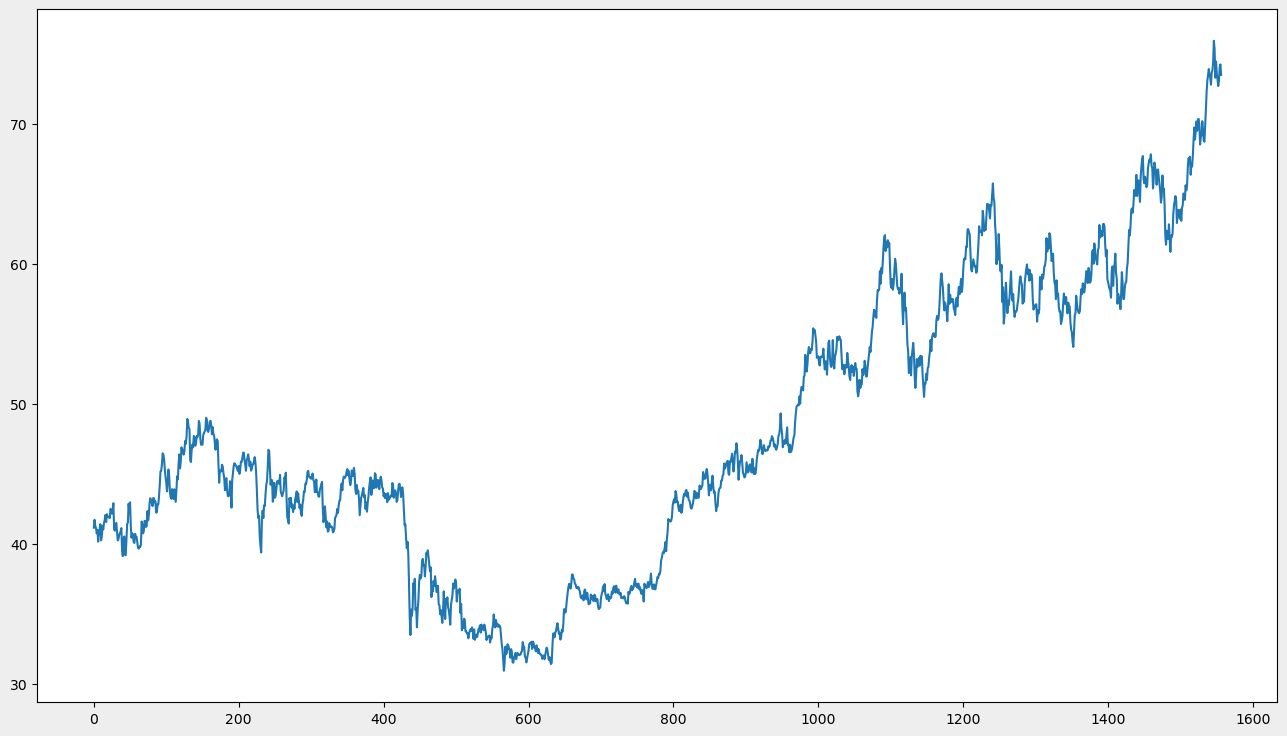

In [13]:
# Covert the dates to UTC timestamps that will be used by the Finnhub API call
timestamp_start = int(dt_start_model_parameter_tuning.replace(tzinfo=timezone.utc).timestamp())
timestamp_end = int(dt_end_model_parameter_tuning.replace(tzinfo=timezone.utc).timestamp())

# Initialize the Client
finnhub_client = finnhub.Client(api_key=finnhub_api_key)

# Get data and put into dataframe.
res = finnhub_client.stock_candles(ticker, granularity, timestamp_start, timestamp_end)
data = pd.DataFrame(res)

# Make Data Backtrader Friendly
dataBacktrader = data
dataBacktrader.columns = ['close', 'high', 'low','open','s','t','volume']

dataBacktrader['date'] = dataBacktrader.apply(lambda row : datetime.utcfromtimestamp(row['t']), axis = 1)
dataBacktrader.drop(['s','t'], axis = 1, inplace=True)
dataBacktrader['openinterest'] = 0

# Plot the data
plt.plot(dataBacktrader['close'])

In [14]:
dataBacktrader

,close,high,low,open,volume,date,openinterest
0,41.15625,41.59375,40.7500,40.93750,4096400,2000-10-19,0
1,41.71875,41.87500,41.1250,41.15625,5374800,2000-10-20,0
2,41.28125,41.81250,40.9375,41.75000,4619800,2000-10-23,0
3,41.12500,41.71875,41.0000,41.71875,5664000,2000-10-24,0
4,40.75000,41.59375,40.5000,41.25000,3913800,2000-10-25,0
...,...,...,...,...,...,...,...
1552,72.73000,73.51000,72.6600,73.30000,4486900,2006-12-22,0
1553,73.09000,73.40000,72.5300,72.64000,4008200,2006-12-26,0
1554,74.04000,74.14000,73.2600,73.28000,5114800,2006-12-27,0
1555,74.28000,74.51000,74.0100,74.26000,4059700,2006-12-28,0


In [15]:
# Create a subclass of Strategy to define the indicators and logic
class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=60,  # period for the fast moving average window
        pslow=128   # period for the slow moving average window
    )
    
    # The __init__ method runs at the start of any stratagy.
    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        
        # Only want to test valid parameters (and workable parameters)
        # otherwise skip the run
        if ((self.p.pfast <= self.p.pslow) and (self.p.pslow - self.p.pfast >= 5)) :
          self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal
        else :
          raise bt.StrategySkipError   

    # The next() method is run each step of the stratagy. 
    # The step of a stratagy is determined by the dataframe and the duraction 
    # between each data point.
    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position
            
    # The stop method runs at the end of a stratagy run. 
    def stop(self):
        print('(FA Period %2d) (SL Period %2d) Ending Value %.2f' %
                 (self.params.pfast, self.params.pslow, self.broker.getvalue()))

In [18]:
# Create array to store the results from all the backtrader runs.
results_list = []

# First we want to initialize our Cerebro object.
cerebro = bt.Cerebro(stdstats=False,maxcpus=None)

# Next we set the amount of cash we want to start out with.
cerebro.broker.setcash(100000.0)

# Next we read in the dataframe with the data we want backtest
dataFrame = bt.feeds.PandasData(dataname=dataBacktrader, datetime='date')
cerebro.adddata(dataFrame)

# Now we load the actual stratagy. Since we want to run the stratagy over a large
# combination of parameters we want to use the optstratagy method. We
# define the range of parameters we want to run over based on the additional arguments.
# Here we are running our stratagy over:
# - pFast = pfast_start to pfast_end, with a stepsize of pfast_step
# - pSlow = pslow_start to pslow_end, with a stepsize of pslow_step
cerebro.optstrategy(SmaCross, pslow=range(pslow_start,pslow_end+1,pslow_step), pfast=range(pfast_start,pfast_end+1,pfast_step))

# Next we add a sizer to the cerebro object. This determines the strategy of how large our buy and 
# sell orders are. Here we fix it top 99% of our portfolio. 
cerebro.addsizer(bt.sizers.PercentSizer, percents=99)

# We are almost there but we now need to add analyzers to the cerebro object.
# These analyzers allow us to extract information about how well the stratagy performed. 
# (Links to more info about these analyzers at the bottom of the post)
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name="sharperatio", timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")

# Finally we want to set how much each tranasction will cost in commision fees. Since I personally
# use Robinhood Ill just set this to 0.
cerebro.broker.setcommission(commission=0)

# Finally we run the model. This will run the stratagy over the wide array of parameters
# we set above. An object is returned which holds all of the results of the runs.
# (And the information we told it to gather from our Analyzers)
results = cerebro.run();

# Next we want to run over this results object and extract the information so it is easily
# readable and indexable. 
for i in range(0, len(results)):  
  # Need to check that this is a run that fully ran
  if (len(results[i]) >= 1) :
    # Temporarily store all the analyzer values into variables. 
    r_strat  = "slow_fast_" + str(results[i][0].params.pslow) + "_" + str(results[i][0].params.pfast);
    r_return = list(results[i][0].analyzers.timereturn.get_analysis().values())[0]*100
    r_sharpe = results[i][0].analyzers.sharperatio.get_analysis()['sharperatio'];
    r_draw   = results[i][0].analyzers.drawdown.get_analysis()['drawdown']/100;
    r_sqn   = results[i][0].analyzers.sqn.get_analysis()['sqn']

    # Append a dictionary which holds all the important results into our results array.
    results_list.append({
       "Stratagy" : r_strat,
       "pslow" : results[i][0].params.pslow,
       "pfast" : results[i][0].params.pfast,
       "Return" : r_return,
       "Sharpe" : r_sharpe,
       "SQN" : r_sqn,
       "Drawdown" : r_draw
    })


# Make the results a Pandas dataframe and give us statsitical information 
# about the values of the runs. 
results = pd.DataFrame(results_list)               
results.describe()

AttributeError: module 'collections' has no attribute 'Iterable'